<a href="https://colab.research.google.com/github/Alkennedy1998/City-Building-AI-Senior-Design-2021/blob/main/Cities_Skylines_deepQ_learning_for_Final_Santa_Clara_Engineering_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q tf-agents

     |████████████████████████████████| 1.2MB 10.7MB/s 


In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.environments import utils



In [ ]:

from matplotlib import cm, colors
from time import sleep
from IPython.display import clear_output
from math import floor
from random import randrange

color_map = colors.ListedColormap(['green','gray','white','blue','black','orange','pink'])
plt.rcParams['figure.figsize'] = [20, 10]

# Game board:
# 0 = Empty
# 1 = Road
# 2 = Residential Zone
# 3 = Commercial Zone
# 4 = Power Plant
# 5 = Hospital
# 6 = Wind Power Plant

class CitiesSkylinesEnvironment(py_environment.PyEnvironment):
  def __init__(self):
    """ 
    Action space is from 0 to 15679
    board space * possible actions
    62*62 = 3844, 3844 - 472, 3136 * 5 = 15680
    """

    self._initial_state = np.zeros((56,56))
    self._state = self._initial_state
    self._game_cycles = 0;

    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=15679, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(56,56), dtype=np.int32, minimum=0, maximum=7, name='observation')
    
    self._episode_ended = False
    self._reward_value = 0
    self._population = 0;
    self._pollution = 0;
    self._power = 0;
    self._income = 0;

    self._residential_count = 0
    self._commercial_count = 0
    self._coal_plant_count = 0
    self._wind_plant_count = 0
    self._hospital_count = 0

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec
  
  def current_time_step(self):
    return self._current_time_step

  def _reset(self):
      self._state = self._initial_state
      self._episode_ended = False
      return ts.restart(np.array(self._state, dtype=np.int32))

  def _step(self, action):
    #Add a while guard to pause the program 

    self._game_cycles += 1

    if action/3136 < 1:
      # Residential zone
      self._population += 4
      self._pollution += 1
      self._residential_count += 1
      #Residences also provide income in form of taxes
      #About $7 per indivudal zone square, roughly 
      self._income += 7

      x,y = self.map_action_to_coordinate(action)
      self._state[x][y] = 2
      #print("Residential Zone Built at " + str(x) + "," + str(y))

    elif action/3136 < 2:
      # Commercial Zone
      self._income += 0.1*self._population
      self._pollution += 5
      self._commercial_count += 1  

      action = action - 3136
      x,y = self.map_action_to_coordinate(action)
      self._state[x][y] = 3
      #print("Commercial Zone Built at " + str(x) + "," + str(y))
    elif action/3136 < 3:
      # Coal Power Plant
      #Placing one square at a time but in game takes up 30 squares, so should divide by 30... will do later once get loss function wokring 
      self._power += 40
      self._income -= 560
      self._pollution += 50
      self._coal_plant_count += 1

      action = action - 3136 * 2
      x,y = self.map_action_to_coordinate(action)
      self._state[x][y] = 4
      #print("Coal Plant Built at " + str(x) + "," + str(y))
    elif action/3136 < 4:
      # Wind Power Plant
      self._power += 30
      self._income -= 300
      self._wind_plant_count += 1

      action = action - 3136* 3
      x,y = self.map_action_to_coordinate(action)
      self._state[x][y] = 5
      #print("Wind Plant Built at " + str(x) + "," + str(y))
    elif action/3136 < 5:
      # Hospital
      # self._population += floor(self._population * 0.15)
      # self._income -= 2000
      self._hospital_count += 1

      action = action - 3136 * 4
      x,y = self.map_action_to_coordinate(action)
      self._state[x][y] = 6
    else:
      raise ValueError('`action` should be less than the max action value 15680')

    reward = self._calculate_reward(self.calculate_adjacency_bonus(x,y))
    if self._game_cycles >= 1000:
      return ts.termination(np.array(self._state, dtype=np.int32), reward)
    else:
      return ts.transition(
          np.array(self._state, dtype=np.int32), reward, discount=1.0)

    
  def map_action_to_coordinate(self,action):
    x = floor(action / 56)
    y = action - x*56

    return(x,y)

  def _calculate_reward(self,adjacency_bonus):
    calculated_reward = 0
    power_demand = self._population * 10

    # Adjacency bonuses
    calculated_reward += adjacency_bonus
    adjacency_bonus = 0
    
    calculated_reward += self._population - self._pollution
    if self._income < 0:
      calculated_reward -= calculated_reward * 0.75
    else: 
      calculated_reward += self._income / 10
    #Rewards decrease scales with difference between power supply and demand
    if self._power < power_demand:
      calculated_reward -= (power_demand - self._power)
    # (calculated _reward * (power_demand - self._power) / power_demand)
    
    return calculated_reward

  def _printStats(self):
    print("Population: " + str(self._population))
    print("Power: " + str(self._power))
    print("Pollution: " + str(self._pollution))
    print("Income: " + str(floor(self._income)))

    print("Residentials: "+ str(self._residential_count))
    print("Commercials: "+ str(self._commercial_count))
    print("Coals: "+ str(self._coal_plant_count))
    print("Winds: "+ str(self._wind_plant_count))
    print("Hospitals: "+ str(self._hospital_count))
    print(floor(self._calculate_reward(0)))

  def calculate_adjacency_bonus(self,x,y):
    bonus_sum = 0
    directions = [(1,0),(0,1),(-1,0),(0,-1)]
    for direction in directions:
      new_x = x + direction[0]
      new_y = y + direction[1]
      if new_x > 0 and new_x < 56 and new_y > 0 and new_y <56:
        if self._state[new_x][new_y] == self._state[x][y]:
          bonus_sum += 150
    return bonus_sum

  def _showMap(self):
    map_view_state = [[0 for x in range(62)] for y in range(62)]
    for x in range(62):
      for y in range(62):
        if x <= 1 or y <= 1 or x >= 60 or y >= 60 or x >= 30 and x <=31 or y >= 30 and y <= 31:
          map_view_state[x][y] = 1
        else:
          transformed_x = x
          transformed_y = y
          if x <= 29 and y <= 29:
            transformed_x -= 2
            transformed_y -= 2
          elif x <= 29:
            transformed_x -= 2
            transformed_y -= 4
          elif y <= 29:
            transformed_x -= 4
            transformed_y -= 2
          else:
            transformed_x -= 4
            transformed_y -= 4
          map_view_state[x][y] = self._state[transformed_x][transformed_y]
    self._printStats()
    plt.imshow(map_view_state, cmap = color_map)
    plt.show()
    sleep(.5)
    clear_output(wait=True)
  
def main():
  plt.figure()
  
  env = CitiesSkylinesEnvironment()
  for x in range(500):
    action = randrange(0,15680)
    env._step(action)

    if x % 50 == 0:
      env._showMap()
      


# main()

In [ ]:
env = CitiesSkylinesEnvironment()
tf_env = tf_py_environment.TFPyEnvironment(env)
train_env = tf_env
eval_env = tf_env


In [ ]:
num_iterations = 400 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 40  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 40  # @param {type:"integer"}

In [ ]:
# Consider layers that go big -> small -> big, e.g.
fc_layer_params = (1024, 256, 64, 256, 1024)
#fc_layer_params = (100, 50)
# Maybe change env -> tf_env
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# it's output.
flatten_layer = tf.keras.layers.Flatten()
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential([flatten_layer] + dense_layers + [q_values_layer])

In [ ]:
optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)
print(q_net)

In [ ]:
print(tf_env.time_step_spec())
print(tf_env.action_spec())
print(q_net)
print(q_net.losses)


TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(56, 56), dtype=tf.int32, name='observation', minimum=array(0, dtype=int32), maximum=array(7, dtype=int32)))
BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(15679, dtype=int32))
[]


In [ ]:
agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())
example_environment = tf_py_environment.TFPyEnvironment(CitiesSkylinesEnvironment)
time_step = example_environment.reset()
random_policy.action(time_step)



PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([6499], dtype=int32)>, state=(), info=())

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


In [ ]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)


-138855.58

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [ ]:
agent.collect_data_spec


Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(56, 56), dtype=tf.int32, name='observation', minimum=array(0, dtype=int32), maximum=array(7, dtype=int32)), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(15679, dtype=int32)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [ ]:
agent.collect_data_spec._fields


('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [ ]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

In [ ]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset
iterator = iter(dataset)
print(iterator)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [ ]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for x in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  #td_targets = dqn_agent.compute_td_targets(q_values_layer, agent.time_step_spec.reward, agent.time_step_spec.discount)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)
    print(eval_env._state)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
step = 40: loss = 0.0
step = 40: Average Return = -3678.375


AttributeError: ignored

(-3457.4, 250.0)

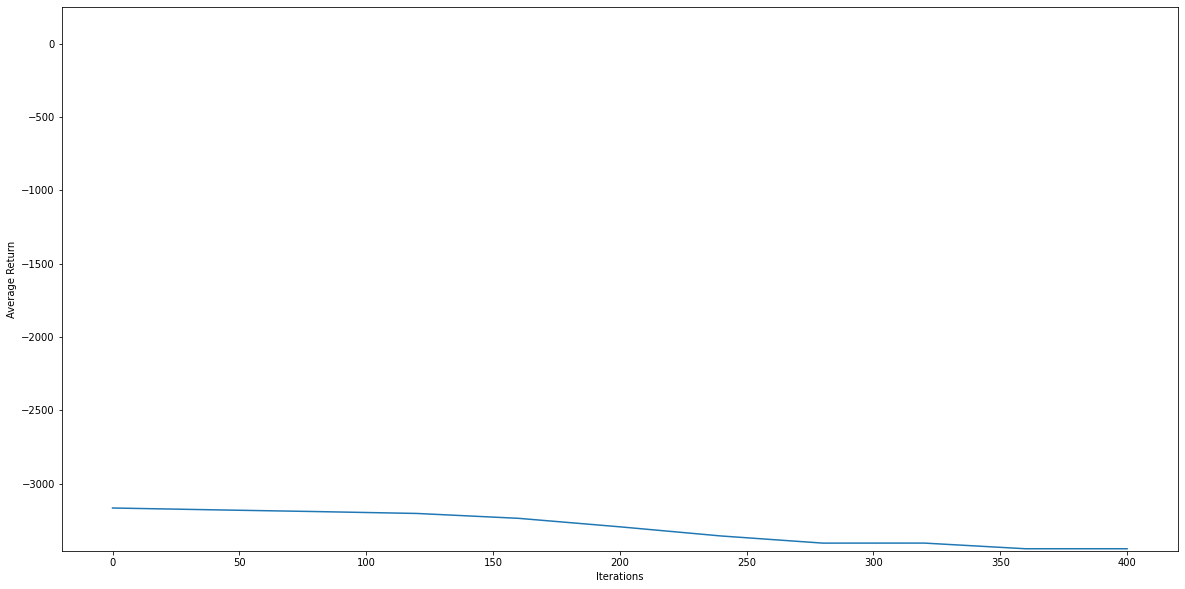

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)